![attnetion](./media/main.gif)

### Self attention

Self-attentoin and attentions are similar. They fundamentally share the same concept and many common mathematical operations. A self-attention module takes in n inputs, and returns n outputs. What happens in this module? In layman’s terms, the self-attention mechanism allows the inputs to interact with each other (“self”) and find out who they should pay more attention to (“attention”). The outputs are aggregates of these interactions and attention scores.

Here we compute basic self attention for three tokens; and steps are:
- Prepare token (input)
- Initialize the weights
- Compute Key, Query, and Value
- compute attention score
- Compute softmax
- Multiply Scores with valeus 


In [2]:
import math
import torch
from torch.nn.functional import softmax
import seaborn as sns
import matplotlib.pyplot as plt

####  Input

In [3]:
input_token = [
  [1, 0, 1, 0], # token 1
  [0, 2, 0, 2], # toekn 2
  [1, 1, 1, 1]  # token 3
 ]
input_token = torch.tensor(input_token, dtype=torch.float32)
input_token

tensor([[1., 0., 1., 0.],
        [0., 2., 0., 2.],
        [1., 1., 1., 1.]])

#### Initialize weights 

Every input must have three representations. These representations are called key (orange), query (red), and value (purple). For this example, let’s take that we want these representations to have a dimension of 3. Because every input has a dimension of 4, this means each set of the weights must have a shape of 4×3.

![kqv](./media/kqv.gif)


Note: *In a neural network setting, these weights are usually small numbers, initialised randomly using an appropriate random distribution like Gaussian, Xavier and Kaiming distributions.*

In [4]:
w_key = [
  [0, 0, 1],
  [1, 1, 0],
  [0, 1, 0],
  [1, 1, 0]
]
w_query = [
  [1, 0, 1],
  [1, 0, 0],
  [0, 0, 1],
  [0, 1, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

print("Weights for key: \n", w_key)
print("Weights for query: \n", w_query)
print("Weights for value: \n", w_value)

Weights for key: 
 tensor([[0., 0., 1.],
        [1., 1., 0.],
        [0., 1., 0.],
        [1., 1., 0.]])
Weights for query: 
 tensor([[1., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 1.]])
Weights for value: 
 tensor([[0., 2., 0.],
        [0., 3., 0.],
        [1., 0., 3.],
        [1., 1., 0.]])


#### Compute Key, Query, Value 

In [19]:
keys = input_token @ w_key

![Key](./media/k.gif)

In [15]:

queries = input_token @ w_query

![Key](./media/q.gif)

In [20]:
values = input_token @ w_value

![Key](./media/v.gif)

In [21]:
print("keys:\n", keys)
print("query: \n", queries)
print("valeus:\n", values)

keys:
 tensor([[0., 1., 1.],
        [4., 4., 0.],
        [2., 3., 1.]])
query: 
 tensor([[1., 0., 2.],
        [2., 2., 2.],
        [2., 1., 3.]])
valeus:
 tensor([[1., 2., 3.],
        [2., 8., 0.],
        [2., 6., 3.]])


Note: *The whole process of computing K, Q, V can be done simply creating linear function from nn module.*

In [ ]:
# eg_linear =torch.nn.Linear(in_features=4, out_features=3, bias=True)
# For each K,Q,V

#### Compute Attention score 

To obtain attention scores, we start off with taking a dot product between Input 1’s query (red) with all keys (orange), including itself. Since there are 3 key representations (because we have 3 inputs), we obtain 3 attention scores (blue).

This is known as dot product attention. There are other score function such as scaled dot product, and additive /concat score fucntion.

In [32]:
attention_scores = queries @ keys.T
for i in range(3):
    print(f"attention score of input token:{i}: {attention_scores[i]} \n")

attention score of input token:0: tensor([2., 4., 4.]) 

attention score of input token:1: tensor([ 4., 16., 12.]) 

attention score of input token:2: tensor([ 4., 12., 10.]) 



![attn](./media/attn.gif)

#### Compute Softmax

In [34]:
softmax_score = softmax(attention_scores, dim=-1)
print(f"softmax score: \n", softmax_score)

softmax score: 
 tensor([[6.3379e-02, 4.6831e-01, 4.6831e-01],
        [6.0337e-06, 9.8201e-01, 1.7986e-02],
        [2.9539e-04, 8.8054e-01, 1.1917e-01]])


In [35]:
# For Illustration, approximate the above as follows
attn_scores_softmax = [
  [0.0, 0.5, 0.5],
  [0.0, 1.0, 0.0],
  [0.0, 0.9, 0.1]
]
attn_scores_softmax = torch.tensor(attn_scores_softmax, dtype=float)
print(attn_scores_softmax)

tensor([[0.0000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.9000, 0.1000]], dtype=torch.float64)


#### Multiply Scores with Value

The softmaxed attention scores for each input (blue) is multiplied with its corresponding value (purple). This results in 3 alignment vectors (yellow). Here, we’ll refer to them as weighted values.

![value mult](./media/val_mul.gif)

#### Scaled Dot Product function

In general, it requires both query and key vector have the same length. We can choose matrix $M$ where $M$ is a matrix suitably chosen for translating between both spaces. 

$\mathbf{q}^\top \mathbf{M} \mathbf{k}$

$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$

In [59]:
class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, dropout) -> None:
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
    
    #Queries: (batch_size, no. of queries, d(embedding size))
    #Keys: (batch_size, no. of queries, d(embedding size))
    #Values: (batch_size, no. of key-value pairs, value dimension)
    #valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [60]:
q = torch.normal(0, 1, (2, 1, 2))
k = torch.normal(0, 1, (2, 10, 2))
v = torch.normal(0, 1, (2, 10, 4))

attention = ScaledDotProductAttention(dropout=0.3)
result = attention(queries=q, keys=k, values=v)
result


tensor([[[ 0.1069,  0.4313,  0.6366, -0.4864]],

        [[ 0.1918,  0.6280,  0.5808,  0.5317]]])

In [63]:
attention.attention_weights

tensor([[[0.1319, 0.0671, 0.0951, 0.0659, 0.0372, 0.0463, 0.1875, 0.1604,
          0.1912, 0.0176]],

        [[0.0627, 0.0340, 0.0858, 0.0997, 0.1751, 0.0716, 0.0707, 0.1301,
          0.2233, 0.0471]]])

#### Additive Attention Score 




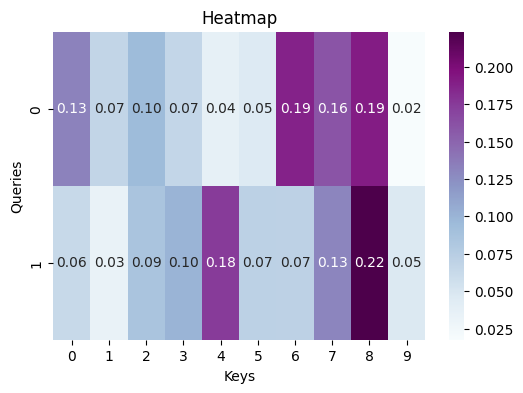

In [80]:
# Create a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(attention.attention_weights.squeeze(), cmap='BuPu', annot=True, fmt=".2f", cbar=True)
plt.title("Heatmap")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.show()

#### Additive Attention

 When queries $q$ and keys $k$ are vectors of different dimension, we can either use a matrix to address the mismatch via $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, or we can use additive attention as the scoring function. Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings.

 $a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}$

 where $\mathbf W_q\in\mathbb R^{h\times q}, \mathbf W_k\in\mathbb R^{h\times k},$ $\mathbf w_v\in\mathbb R^{h}$


In [85]:
class AdditiveAttention(torch.nn.Module):
    def __init__(self, num_hiddens, dropout, ):
        super().__init__()
        self.w_k = torch.nn.LazyLinear(num_hiddens, bias=False)
        self.w_q = torch.nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = torch.nn.LazyLinear(1, bias=False)
        self.dropout = torch.nn.Dropout(dropout)
        
    # queries: (batch_szie, num of queries, 1, num_hiddens)
    # keys: (batch_szie, 1, num of key-value pairs, num_hiddens)
    # values: (batch_size, no. of key-value pairs, value dimension)
    def forward(self, queries, keys, values, valid_lens=None):
        queries, keys = self.w_q(queries), self.w_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        
        self.attention_weights = softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [87]:
queries = torch.normal(0, 1, (2, 1, 20))
additive_attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
results = additive_attention(queries=queries, keys=k, values=v)

/home/whiskey/miniconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [88]:
additive_attention.attention_weights

tensor([[[0.1020, 0.0892, 0.0922, 0.1153, 0.0886, 0.1075, 0.0909, 0.1138,
          0.1099, 0.0904]],

        [[0.0901, 0.0813, 0.0952, 0.1010, 0.1240, 0.0922, 0.0903, 0.1174,
          0.1253, 0.0831]]], grad_fn=<SoftmaxBackward0>)

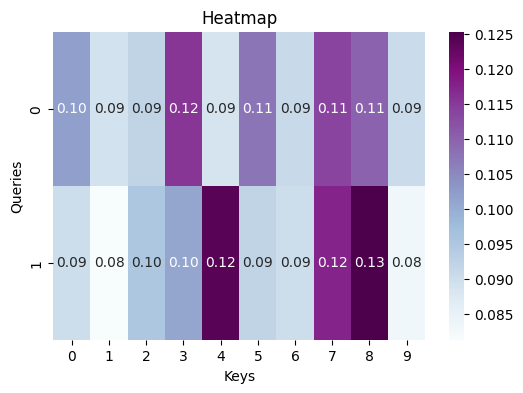

In [93]:
# Create a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(additive_attention.attention_weights.squeeze().detach().numpy(), cmap='BuPu', annot=True, fmt=".2f", cbar=True)
plt.title("Heatmap")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.show()

### Illustrations 

##### Input Embedding 

Tokenizer:

Tokenization is the process of breaking down a text or a sequence of characters into smaller units called tokens. Tokens can be words, subwords, or even individual characters, depending on the tokenizer and the specific task at hand

- Word tokenizer: This tokenizer splits text into individual words based on spaces or punctuation marks.
- Sentence tokenizer: Sentence tokenization divides a text into sentences. It identifies the boundaries between sentences based on punctuation marks like periods, exclamation marks, and question marks.
- Subword tokenizer: Subword tokenization breaks text into smaller units that are smaller than words, often using techniques like Byte-Pair Encoding (BPE), SentencePiece, or WordPiece. This is commonly used in neural machine translation and other NLP tasks. Subword tokenization can handle out-of-vocabulary words by splitting them into subword units.
- Character tokenizer: Character tokenization breaks text into individual characters. Each character becomes a separate token. This type of tokenizer is useful for character-level language modeling and some text generation tasks.
- N-gram rokenizer: An N-gram tokenizer splits text into contiguous sequences of N tokens, which can be words, subwords, or characters. For example, a bigram tokenizer would split the sentence "I love NLP" into ["I love", "love NLP"].
- Whitespace tokenizer: This tokenizer splits text based on whitespace characters (spaces, tabs, line breaks). It's a simple way to tokenize text, but it may not handle all cases well, especially when dealing with languages that don't use spaces to separate words.
- Pre-trained tokenizer:  BERT, GPT-2


![input embedding](./media/ie.png)


#### Positional Encoding

![PE](./media/pe.png)

![PE1](./media/pe1.png)

##### Q, K, V

![QKV](./media/qkv.png)

#### Multihead Attention (Encoder)

$seq = sequence length$

$d_{model} = size of embedding vector$

$h = number of heads$

$d_k = d_v = d_{model} / h$


![MH](./media/mh.png)



#### Multihead Attention (Decoder)

#### Layer Normalization 

![LN](./media/ln.png)